# 1 Getting started with image processing in Python
This is module notes for a crash course on image processing using python 3, the skimage and the matplotlib packages, and the jupyter editor.

It is not assumed that the student can program and has any background in image processing. It is not a course in the python language, but some exposure to python is needed. The pedagogical plan is: Copy, modify, create. That is, first the student copies code, verify that it works, and reflects on the output. Secondly, some existing code is modified to suit new tasks. Finally, solutions to completely new problems are created by combining and modifying existing code, knowledge, and experiments. Some assignments have been added for the student to test his/her understanding of the material.

The module uses 2 images: A green image mainly showing the location of cilia, and a red image showing the location of a protein of interest. The images were provided by Lotte B. Pedersen, University of Copenhagen, for details see Pedersen et al., "Endocytic control of cellular signaling at the primary cilium", Trends in biochemical sciences, 2016.

The overall task will be to estimate the amount of protein near the cilia using image processing and Python. In this module, we will first look at how to combine the two images programmatically to visually inspect the relation between the cilia and the protein, and later we will make a program to more precisely estimate the amount of protein near the cilia.

# 1.1 Preliminaries
To solve the two tasks, we first need to get familiar with Python and basic operations on images.

## 1.1.1 Setup python with additional functions and modified default values
First we read some libraries of functions, that we will need, and we setup jupyter's way of handling images.

In [3]:
from skimage import io, morphology, color
from matplotlib import pyplot as plt, cm
import numpy as np
plt.rcParams['image.cmap'] = 'gray' # set default colormap for imshow to be gray

## 1.1.2 Images as tables of numbers
To analyze images, we must read them into memory first. We may do this using the 'imread' function in the skimage.io library. Once read, we can show them on the screen. This is done as follows:

Text(0.5, 1.0, 'Cilia')

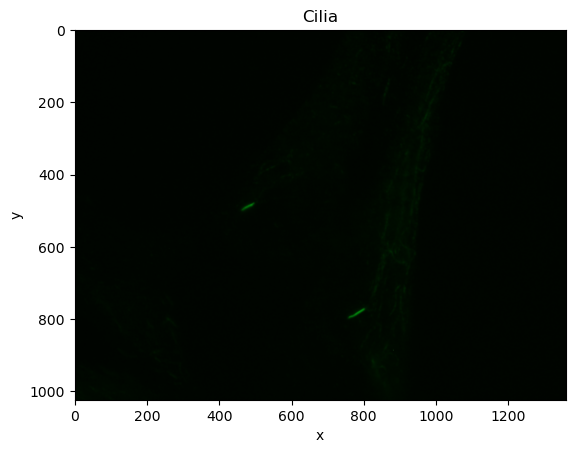

In [5]:
cilia = io.imread("Image_34362.tif")
plt.imshow(cilia)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Cilia')

Image_34362.tif is a file containing a digital image, meaning that the light in the microscope has been sampled on a regular grid and stored in a table. This table is now stored in memory, and we chose to call the table cilia.

**Assignment 1a:** Read the image "Image_34363.tif", call it protein, and display it on screen.

Text(0.5, 1.0, 'Protein')

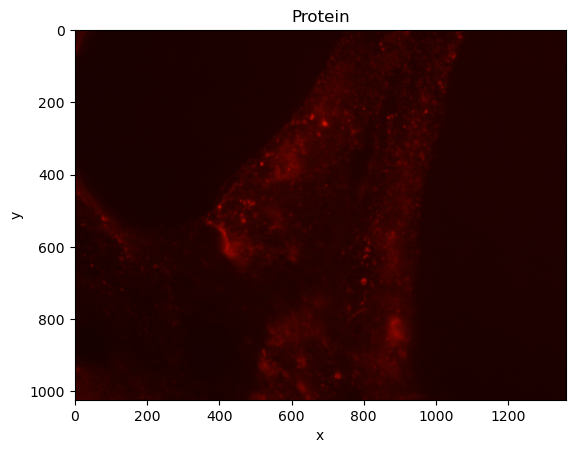

In [6]:
protein = io.imread("Image_34363.tif")
plt.imshow(protein)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Protein')

We can probe properties of this table using builtin syntax, for example, if we wish to know what type the image is and how big it is, we can use the print function, which writes stuff to the screen, together with special syntax for various information about the image:

In [ ]:
print('The image is of type', type(cilia))
print('The image has dimensions:', cilia.shape)
print("The total number of values are:", cilia.size)

What Python tells us is that it is a 3-dimensional numpy array, where numpy was one of the libraries we read in the beginning, and an array is another word for a table. Further, we are told that there are 1024 different coordinates along the first axis, 1360 and 3 along the second and third axis. This is typical for a color image, which consists of 3 color channels red, green, and blue. Note that the size property of the cilia object returns the product of 1024, 1360, and 3, but for a color image, we often think of the triple (red, green, blue) as a unit and say that the size of the image is 1024 x 1360. The elements of the 3-dimensional table can be printed directly,

In [ ]:
print("Its values are", cilia)

What we see are the raw intensities of the image. The pixel in the top corner has (red,green,blue) color [0,5,0], its neighbour is [0,4,0] etc. The image values can be read by indexing, e.g., the top left corner of the red, green and blue channels have indices [0,0,0], [0,0,1], [0,0,2] and the neighbouring (along the second dimension) have indices  [0,1,0], [0,1,1], [0,1,2]:

In [ ]:
print("The values of the top corner are (",cilia[0,0,0],",",cilia[0,0,1],",",cilia[0,0,2],")")
print("The values of the neighbour are (",cilia[0,1,0],",",cilia[0,1,1],",",cilia[0,1,2],")")
print("The type of cilia[0,0,0] is",type(cilia[0,0,0]))

We see that each value has the type 'uint8' which means that it is an unsigned 8-bit integer, which can hold integer values in the range of (0,255). It is typically more practical to access the table-values in groups using slicing. For example, the 3 color values [0,0,0], [0,0,1], [0,0,2] can be access using [0,0,0:3] or equivalently [0,0,:]. For example, the image of all the red values, also known as the the red channel is cilia[:,:,0], and all 3 channels can be shown individually as follows:

In [ ]:
plt.xlabel('x')
plt.ylabel('y')
plt.title('red channel')
plt.imshow(cilia[:,:,0])
plt.show() # Flush the image to screen, since the next 'imshow' is to show a new image
plt.xlabel('x')
plt.ylabel('y')
plt.title('green channel')
plt.imshow(cilia[:,:,1])
plt.show()
plt.xlabel('x')
plt.ylabel('y')
plt.title('blue channel')
plt.imshow(cilia[:,:,2])
plt.show()

Above we imshow'ed each channel separately and used plt.show() to force every image to be shown on the screen. The code consists of 3 similar chunks, which often happens in programming. The code is relatively long and difficult to correct. E.g., if we decide that instead of 'x' we want to write 'x (micrometer)', then we must correct the code in many places with the risk of missing a line or adding mistakes. Therefore, it is better to use a loop structure. A common loop is the for-loop, and rewriting the above as a for-loop looks like:

In [ ]:
for i in range(3):
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Channel " + str(i))
    plt.imshow(cilia[:,:,i])
    plt.show()

This is to be read as follows: Everything indented under the for keyword is repeated. Here it is repeated 3 times, where the counter value i first is 0, then 1, and finally 2. In the title function, we used the addition operator for strings, which concatenates 2 strings, and the str function, which converts a value type to a string. The code is now more compact, and an update of the axis label needs only be done in one place to have an effect on all the 3 figures.

## 1.1.3 Histograms of images
The image values are the raw data captured in the microscope, and their histogram is a useful initial analysis of the image. E.g., the histogram will tell us if the image is over- or under-saturated if the values cluster near the minimum and maximum possible values, which are 0 and 255 for uint8 types. To see the histogram of the green channel of cilia we write:

In [ ]:
print("The image values range from", cilia[:,:,1].min(), "to", cilia[:,:,1].max())
plt.hist(cilia[:,:,1].flatten(),100)
plt.xlabel('value')
plt.ylabel('count')
plt.title('All green values in cilia')

The histogram only works with 1-dimensional table, so the above 'flattens' the 3-dimensional table before the histogram function is called. The values span the interval (0,142), but the histogram shows that most values are below  20. 

**Assignment 1b**: Show histogram of the red and blue channels of cilia. Consider under which circumstances it may be useful to show the histogram of all the image values and not per channel as done here.

**Assignment 1c:** Show histogram of the values of the protein table.

Often images have been captured such that they don't use the full range of possible values. For example, the green channel only uses about half the possible range of uint8, and hence looks dark. To better see the structures in the image, we may stretch the intensities linearly. For example, we can make a new image of the green channel, whose values have been stretched to the range (0,255) as follows:

In [ ]:
green = cilia[:,:,1]
print("The image values range from", green.min(), "to", green.max())
stretched = 255.0*(green-green.min())/(green.max()-green.min())
print("The image values range from", stretched.min(), "to", stretched.max())
plt.xlabel('x')
plt.ylabel('y')
plt.title('stretched green channel')
plt.imshow(stretched)
plt.show()
plt.hist(stretched.flatten(),100)
plt.xlabel('value')
plt.ylabel('count')
plt.title('All values in cilia')

When performing arithmetic on a computer, it is very important to understand the types and their limitations. Uint8 only has very few values, no negative, and no fractional values. In the above, part of the calculation maps outside the set of integers in the interval (0,255). To ensure that the calculation, in the end, is correct, we write '255.0' instead of '255' to force the calculation to be in the float type. The float type is a good representation of all rational numbers.

In some cases, it is useful to convert a color image into a gray-value image, e.g., if the color captured is a mixture of red, green, and blue, but we are only interested in how much light there was and not its color components. Python is designed to make such computations simple. For example, to make a new image where each pixel is the sum of red and green pixels, we may write:

In [ ]:
redGreen = cilia[:,:,0]+cilia[:,:,1]
plt.xlabel('x')
plt.ylabel('y')
plt.title('sum of red and green')
plt.imshow(redGreen)

**Assignment 1d:** Calculate the image where each pixel is the average of the corresponding pixels in the 3 channels and plot it as a single figure. Print the minimum and maximum value of all the values in all the channels of the initial image, print the the minimum and maximum value of the average image? Does the values meet your expectations?

# 2 Visual inspection of the amount of protein near the cilia
To visually assess the amount of protein near the cilia, we will make a composite image programmatically. The cilia image is mainly green and the protein image is mainly red. This is lucky because then our composite image can be made by combining the green channel from cilia with the red channel from protein.

In [ ]:
# beware, must use copy otherwise composit changing imCombine would alse change cilia.
# If you want to know more, seek out information on the difference between copy by reference and by value.
composit = cilia.copy() 
composit[:,:,0] = protein[:,:,0]
composit[:,:,2] = 0 # All values in the blue channel are set to zero! 
plt.imshow(composit)
plt.xlabel('column')
plt.ylabel('row')
plt.title('composit image')

Alternatively, we could make an average of the two images. This is more complicated since imshow insists on the data being in the range (0,1) for floats or (0,255) for integers. So we stretch the image to the range (0,1).

In [ ]:
altComposit = (cilia+protein)/2.0
altComposit = (altComposit-altComposit.min())/(altComposit.max()-altComposit.min())
plt.imshow(altComposit)
plt.xlabel('column')
plt.ylabel('row')
plt.title('average composit image')

For both composites, we see that there are protein many places and that some coincide with one of the cilium.

The resulting image can be saved to disk. Unfortunately, we have to convert it to a uint8 type first remembering to stretch it from the interval (0,1) to (0,255):

In [ ]:
altCompositUint8 = 255.0*altComposit
altCompositUint8 = altCompositUint8.astype(np.uint8)
io.imsave('CombinationOfTwo.tiff',altCompositUint8)

# 3 Programmatical estimation of the amount of protein near the cilia.
In the following, we will estimate the amount of protein near the cilia. The strategy for estimating the amount of protein near the cilia will be 
1. Segment the cilia.
2. Expand the segments slightly.
3. Sum the intensity values in the protein image under the expanded cilia mask.

## 3.1 Segmenting by Thresholding
The cilia are mainly green, and we have seen that by luck this is mostly captured in the green channel. Thus, in the following, we will work with:

In [ ]:
green = cilia[:,:,1]
print('(',green.min(),',',green.max(),')')

Thresholding is the process of converting an image into a binary or boolean image, where the value 1 or true denotes pixels that belong to the segment and 0 or false denotes pixels that do not. In our case, high values correlate with the location of the cilia and we use the '>' comparison operator (on each pixel):

In [ ]:
segm = green > 25
print("segm type:", type(segm))
print("segm size:", segm.shape)
print("segm pixel type:", type(segm[0,0]))
plt.imshow(segm)
plt.xlabel('column')
plt.ylabel('row')
plt.title('cilia segm')

We see that the image is 'false' where the green channel of cilia has low values. It is 'true' where values higher than 25 are. The threshold 25 was arbitrarily chosen, so let's investigate several thresholds:

In [ ]:
threshold = [25,30,35]
noThresholds = len(threshold)
for i in range(noThresholds):
    segmTest = green > threshold[i]
    plt.imshow(segmTest)
    plt.title("Threshold " + str(threshold[i]))
    plt.xlabel('color index')
    plt.ylabel('count')
    plt.show()

**Assignment 1e:** Repeat the above code but experiment with other threshold values. Which do you think works best and why?

## 3.2 Mathematical Morphology
The mask shows where the green pixels are, and we would like to investigate the red pixels in the vicinity of the green. So we use Mathematical Morphology to enlarge the mask slightly. Mathematical morphology has two basic operations: dilation and erosion. Dilation means to expand and erosion the opposite. Technically this is done by interacting the segments with a shape, also known as a structuring element. Here we use the simplest structuring element, a disk of radius 10, and to expand the cilia mask we use dilation:

In [ ]:
dsk = morphology.disk(10)
msk = morphology.binary_dilation(segm,dsk)
plt.imshow(msk)
plt.xlabel('column')
plt.ylabel('row')
plt.title('Dilated green mask')

We see that the cilia segments have been expanded, and close inspection will reveal, that they have been expanded with about 20 pixels in an outward direction. Due to its later use, we call the dilated segmented image, the mask.

**Assignment 1f:** Make a for-loop that tests different disk-radii and choose one that you think will work well for combining it with the protein image.

## 3.3 Summing in the protein image
The protein image is mainly red, and by luck this is captured mainly in the red channel. So, in the following, we will use:

In [ ]:
red = protein[:,:,0]
print('(',red.min(),',',red.max(),')')

The mask can be used to select pixels in the protien image by multiplication.

In [ ]:
redMsk = red*msk
plt.imshow(redMsk)
plt.xlabel('column')
plt.ylabel('row')
plt.title('redMsk segm')

We see that one cilium has more protein in its vicinity than the other. In this module, we are only interested in summary statistics, so we sum the pixel values in the protein image and compare this with the number of pixels in the mask image.

In [ ]:
print("Sum of redMsk:",redMsk.sum())
print("Area of msk:",msk.sum())
print("Average value:", redMsk.sum()/msk.sum())

**Assignment 1g:** Assume that we are interested in the number of high values in the protein image near the cilia, make a program, which chooses a suitable threshold for the protein image and count the number of pixels that are both high in protein and near the cilia.